# generating videos of motion
Tim Tyree<br>
12.6.2020

In [1]:
%matplotlib inline
from lib.my_initialization import *
from lib.controller.integrate_forward_dormand_prince_asynchronous import *
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


# import mesh

In [22]:
#define Lamé parameters
mu = 1.; lam = 10.; 
#define coefficient for Rayleigh damping
gamma = .05#1.#1.;

#define adaptive time stepping absolute tolerances
salience = 2#128#32
learning_rate = np.log(salience) #np.log(16) #np.log(2)
lasso_fraction = 0.5#0.5
v_scale = 2.
mass_density=1.

stepsize_init = 0.0001#0.00001  #0.0001
atol_x = 0.0001#0.001#1e-7; 
atol_v = 0.0001#0.001#1e-7; 
btol_x = 0.00001#0.001#1e-10; 
btol_v = 0.00001#0.001#1e-10; 


#path to mesh
input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
#where to save results
data_folder =  os.path.join(nb_dir,'../data/mov_csv')
# data_fn = f"avi_esynchronous_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# data_fn = f"avi_ns_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
data_fn = f"avi_ns_asynch_fixed_lr_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
save_folder_vid = '../vid/tmp'
folder_vid = '../vid'
# data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')

os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
input_file_name = os.path.join(nb_dir,input_file_name)
tme = 0.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
N_elements = element_array_index.shape[0]
N_vertices = node_array_position.shape[0]
print(list(dict_values_system.keys()))

#header to start of video
# TEXT = '''TEXT=$'Synchronous Variational Integrator\nDamped Neohookean Model\n(inward squish)''''
# TEXT = f"""
# TEXT=$'an inward squish
#         Synchronous Variational Integrator 
#         Explicit Newmark Method
        
#         Undamped Neohookean Model
#         mu {mu}  lambda {lam} gamma {gamma}
        
#         Spherical Mesh
#         Num. Vertices {N_vertices}
#         Num. Elements {N_elements}
# '"""


TEXT = f"""
TEXT=$'an inward squish
        Asynchronous Variational Integrator 
        Dormand–Prince Method
        
        Undamped Neohookean Model
        mu {mu}  lambda {lam} gamma {gamma}
        
        Spherical Mesh
        Num. Vertices {N_vertices}
        Num. Elements {N_elements}
'"""

#write header to file
# print(TEXT)
# Dormand–Prince Method
# Explicit Newmark Method
# Implicit Midpoint Rule

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


# Explicit/Implicit Synchronous/Asynchronous Variational Integrator
- Mesh = solid sphere discretized by tetrahedra 
- Forces = neohookean hyperelastic material with rayleigh damping
- Initialization = inward initial velocity by an amount proportional to the x coordinate.

In [23]:
#initialize system
tauK = element_array_time
tau = node_array_time

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

#initialize stepsizes of simulation
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]


# #perturb momentum in the x direction and let it run overnight with a small timestep  
velocities[:,0] = -v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []
stepsize_count_lst = []
frac_lb = lambda i: np.exp(learning_rate*i)  ##np.exp((i+.5)*learning_rate/10)
learning_bins = np.array([stepsize_init*frac_lb(i) for i in np.arange(-15,15)])

# #this looks nice. 30 bins
# learning_bins = np.array([0.00480198, 0.00480886, 0.00481574, 0.00482262, 0.00482951,
#         0.00483639, 0.00484327, 0.00485015, 0.00485703, 0.00486391,
#         0.0048708 , 0.00487768, 0.00488456, 0.00489144, 0.00489832,
#         0.0049052 , 0.00491209, 0.00491897, 0.00492585, 0.00493273,
#         0.00493961, 0.00494649, 0.00495338, 0.00496026, 0.00496714,
#         0.00497402, 0.0049809 , 0.00498778, 0.00499467, 0.00500155,
#         0.00500843])

# #let's try 100 bins
learning_bins = np.array([0.00477609, 0.00477838, 0.00478067, 0.00478296, 0.00478526,
        0.00478755, 0.00478984, 0.00479214, 0.00479443, 0.00479672,
        0.00479902, 0.00480131, 0.0048036 , 0.0048059 , 0.00480819,
        0.00481048, 0.00481277, 0.00481507, 0.00481736, 0.00481965,
        0.00482195, 0.00482424, 0.00482653, 0.00482883, 0.00483112,
        0.00483341, 0.00483571, 0.004838  , 0.00484029, 0.00484258,
        0.00484488, 0.00484717, 0.00484946, 0.00485176, 0.00485405,
        0.00485634, 0.00485864, 0.00486093, 0.00486322, 0.00486552,
        0.00486781, 0.0048701 , 0.0048724 , 0.00487469, 0.00487698,
        0.00487927, 0.00488157, 0.00488386, 0.00488615, 0.00488845,
        0.00489074, 0.00489303, 0.00489533, 0.00489762, 0.00489991,
        0.00490221, 0.0049045 , 0.00490679, 0.00490908, 0.00491138,
        0.00491367, 0.00491596, 0.00491826, 0.00492055, 0.00492284,
        0.00492514, 0.00492743, 0.00492972, 0.00493202, 0.00493431,
        0.0049366 , 0.0049389 , 0.00494119, 0.00494348, 0.00494577,
        0.00494807, 0.00495036, 0.00495265, 0.00495495, 0.00495724,
        0.00495953, 0.00496183, 0.00496412, 0.00496641, 0.00496871,
        0.004971  , 0.00497329, 0.00497558, 0.00497788, 0.00498017,
        0.00498246, 0.00498476, 0.00498705, 0.00498934, 0.00499164,
        0.00499393, 0.00499622, 0.00499852, 0.00500081, 0.0050031 ,
        0.00500539])

# learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
print(f"learning_bins are {learning_bins}")

learning_bins are [0.00477609 0.00477838 0.00478067 0.00478296 0.00478526 0.00478755
 0.00478984 0.00479214 0.00479443 0.00479672 0.00479902 0.00480131
 0.0048036  0.0048059  0.00480819 0.00481048 0.00481277 0.00481507
 0.00481736 0.00481965 0.00482195 0.00482424 0.00482653 0.00482883
 0.00483112 0.00483341 0.00483571 0.004838   0.00484029 0.00484258
 0.00484488 0.00484717 0.00484946 0.00485176 0.00485405 0.00485634
 0.00485864 0.00486093 0.00486322 0.00486552 0.00486781 0.0048701
 0.0048724  0.00487469 0.00487698 0.00487927 0.00488157 0.00488386
 0.00488615 0.00488845 0.00489074 0.00489303 0.00489533 0.00489762
 0.00489991 0.00490221 0.0049045  0.00490679 0.00490908 0.00491138
 0.00491367 0.00491596 0.00491826 0.00492055 0.00492284 0.00492514
 0.00492743 0.00492972 0.00493202 0.00493431 0.0049366  0.0049389
 0.00494119 0.00494348 0.00494577 0.00494807 0.00495036 0.00495265
 0.00495495 0.00495724 0.00495953 0.00496183 0.00496412 0.00496641
 0.00496871 0.004971   0.00497329 0.00497558 0

In [24]:
#choose your fighter
# integrate_system_explicit_synchronous = get_integrate_system_explicit_synchronous(mu,lam,gamma)
# integrate_system_implicit_synchronous = get_integrate_system_implicit_synchronous(mu,lam,gamma,num_iter=30)
# integrate_system_dormand_prince_synchronous = get_integrate_system_dormand_prince_synchronous(mu,lam,gamma)
integrate_system_dormand_prince_asynchronous = get_integrate_system_dormand_prince_asynchronous(mu,lam,gamma,atol_x, atol_v, btol_x, btol_v,learning_rate, lasso_fraction)
# integrate_system_explicit_asynchronous = get_integrate_system_explicit_asynchronous(mu,lam,gamma)

#(optional) #view the mesh
# plot_mesh(vertices, input_file_name=input_file_name, darkmode=True)

In [25]:
#prepare for video
frameno = 1
time_between_observations = 0.01
time_of_next_observation = tme + time_between_observations

#empty the temporary folder, vid/tmp
os.chdir(nb_dir)
os.chdir(folder_vid)
!rm -r tmp
os.mkdir('tmp')

with open("mov/text.txt", "w") as file:
    file.write(TEXT)
    file.close()

In [26]:
#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)
time_end_recording = 3#.2
while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
#     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
#                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
            node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
#     integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,
#                                              element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
    try:
        img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
    except:
        pass
    save_fn_img = f'img{frameno:09}.png'
    frameno += 1
    Img = Image.fromarray(img)
    Img.save(save_fn_img)
    del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
beep(3)

/Users/timothytyree/Documents/GitHub/avi/nb/lib/controller/integrate_forward_dormand_prince_asynchronous.py:97: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  max_err, mav_err, x_out,v_out = one_step_explicit_dormand_prince_method(h,x,v,K_masses,K_tau,tau_of_K,Bm)


KeyboardInterrupt: 

In [27]:
print(time_of_next_observation)
from scipy.stats.mstats import gmean
# print(np.hmean(element_array_stepsize), gmean(element_array_stepsize))
print(gmean(element_array_stepsize))

1.9600000000000015
9.999159564889666e-05


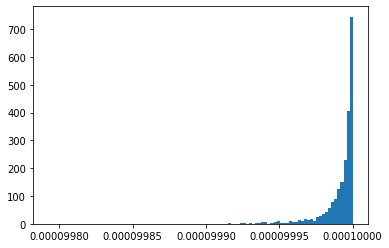

In [28]:
plt.hist(element_array_stepsize, bins=100)
plt.show()

In [29]:
# img = get_img_of_system(vertices, input_file_name, darkmode = True, text=f'time={tf:.2f}')
# img
stepsize_init

0.0001

__problem/bug confirmed__ integrate_system_dormand_prince_asynchronous is only decreasing the stepsize values.

## Verified that all variables are changed by the integrator

__time is now being updated at the nodes__

# save csv of results

In [30]:
df = pd.DataFrame({
    't':tme_lst,
    'volume':volume_lst,
    'energy':energy_lst,
    'stepsize_mean':stepsize_mean_lst,
    'stepsize_std':stepsize_std_lst,
    'stepsize_median':stepsize_median_lst,
})

In [31]:
df.head()

,t,volume,energy,stepsize_mean,stepsize_std,stepsize_median
0,0.01,3.746652,1.283282,0.0001,1.117040e-09,0.0001
1,0.02,3.707442,1.144023,0.0001,1.930056e-09,0.0001
2,0.03,3.682417,1.054085,0.0001,2.614296e-09,0.0001
3,0.04,3.667982,0.992274,0.0001,3.198742e-09,0.0001
4,0.05,3.661667,0.944847,0.0001,3.708373e-09,0.0001


In [32]:
# x_values = df['t'].values
# # y_values = df['volume'].values
# y_values = df['energy'].values
# plt.plot(x_values, y_values)

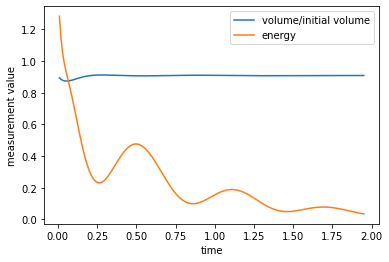

In [33]:
x_values = df['t'].values
# y_values = df['volume'].values
# y_values = df['energy'].values
plt.plot(x_values, df['volume'].values/(4*np.pi*1.**3/3), label='volume/initial volume')
plt.plot(x_values, df['energy'].values, label='energy')
plt.legend()
plt.xlabel('time')
plt.ylabel('measurement value')
plt.show()

In [34]:
# data_fn = f"avi_ns_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}.csv"

os.chdir(data_folder)
df.to_csv(data_fn, index=False)

In [35]:
print(f'results saved as {data_fn}')

results saved as avi_ns_asynch_fixed_lr_spherical_mesh_64_mu_1.0_lambda_10.0_gamma_0.05vscale_2.0_stepsizeinit_0.0001_salience_2_atolx_0.0001.csv


In [36]:
np.array(stepsize_count_lst)
# np.savez(data_fn_counts)
np.save(data_fn_counts, np.array(stepsize_count_lst))

In [18]:
# set(stepsize_count_lst)
np.array(stepsize_count_lst[0])
np.array(stepsize_count_lst[-1])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# compile and save the movie using ffmpeg

In [37]:
os.chdir(nb_dir)
os.chdir(os.path.dirname(save_folder_vid))
vid_in_fn = 'out.mov'
vid_out_fn = data_fn.replace('.csv','.mov')

In [38]:
!./concat_folder_png.sh

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.3.1_4 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 51.100 /

[aac @ 0x7fd1e0806e00] Qavg: 120.000
ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.3.1_4 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-ind

Input #0, mpegts, from 'mov/tmp/tmp2.MTS':
  Duration: 00:00:11.81, start: 1.405756, bitrate: 3957 kb/s
  Program 1 
    Metadata:
      service_name    : Service01
      service_provider: FFmpeg
    Stream #0:0[0x100]: Video: mpeg2video (Main) ([2][0][0][0] / 0x0002), yuv420p(tv, progressive), 1280x720 [SAR 1:1 DAR 16:9], 60 fps, 60 tbr, 90k tbn, 120 tbc
    Side data:
      cpb: bitrate max/min/avg: 0/0/0 buffer size: 49152 vbv_delay: N/A
    Stream #0:1[0x101](und): Audio: mp2 ([3][0][0][0] / 0x0003), 44100 Hz, stereo, fltp, 384 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (mpeg2video (native) -> h264 (libx264))
  Stream #0:1 -> #0:1 (mp2 (native) -> aac (native))
Press [q] to stop, [?] for help
[libx264 @ 0x7ff8b78bb000] using SAR=1/1
[libx264 @ 0x7ff8b78bb000] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x7ff8b78bb000] profile High, level 3.2, 4:2:0, 8-bit
[libx264 @ 0x7ff8b78bb000] 264 - core 161 r3027 4121277 - H.264/MPEG-4 AVC codec - Copyleft

In [39]:
assert(os.path.exists(vid_in_fn))
destination = shutil.copyfile(vid_in_fn, vid_out_fn) 
beep(2)

0

In [40]:
os.path.exists(vid_out_fn)

True

In [41]:
vid_out_fn

'avi_ns_asynch_fixed_lr_spherical_mesh_64_mu_1.0_lambda_10.0_gamma_0.05vscale_2.0_stepsizeinit_0.0001_salience_2_atolx_0.0001.mov'